In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
# import timeit
from scipy.integrate import odeint
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
import modelSystems as ms

%matplotlib notebook

In [2]:
A = np.array([[1/3,-1/2],[5/4,3/2]])

def linearSystem(x,t):
     return A @ x

def Mease(x,t):
    a = 0.01
    
    (x1,x2) = x
    
    x1p = -x1-a*(x1+19*x2)*(x1+x2)-18*a**2*(x1+x2)**3
    x2p = -10*x2-2*a*(4*x1-5*x2)*(x1+x2)+18*a**2*(x1+x2)**3
    
    return (x1p, x2p)

U, E, V = la.svd(A)

print(f"{U}, \n{E},\n {V}")

[[ 0.09525987 -0.99545244]
 [-0.99545244 -0.09525987]], 
[1.96071373 0.57377065],
 [[-0.61842901 -0.78584067]
 [-0.78584067  0.61842901]]


In [3]:
# x0 = np.real(eivec[1])
x0 = np.array([1,1])
t = np.linspace(0,200,num=2**12)

ts = odeint(linearSystem, x0, t)
"""
ts = np.zeros((2**12,2))
ts[0,:] = x0
for i in range(2**12-1):
    ts[i+1] = A @ ts[i]
"""
# ts = odeint(linearSystem, x0, t)

'\nts = np.zeros((2**12,2))\nts[0,:] = x0\nfor i in range(2**12-1):\n    ts[i+1] = A @ ts[i]\n'

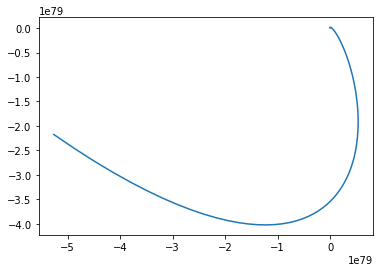

In [4]:
plt.plot(ts @ V[0,:], ts @ V[1,:])

In [5]:
X = ts[:-1]
Y = ts[1:]

In [6]:
print(U, E, V)

[[ 0.09525987 -0.99545244]
 [-0.99545244 -0.09525987]] [1.96071373 0.57377065] [[-0.61842901 -0.78584067]
 [-0.78584067  0.61842901]]


In [7]:
# timescaleInfo(X,Y,x0,0)

In [8]:
A

array([[ 0.33333333, -0.5       ],
       [ 1.25      ,  1.5       ]])

In [9]:
Xr = ms.generateTimeSeriesContinuous('Lorenz', np.array([1,5,17]))


In [10]:
def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

"""
def delayEmbed(Xin, Yin,assignment,embInterval):
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            lag = 1
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    return (Xin, Yin)
"""

def delayEmbed(D, predHorizon, nLags, embInterval, t = None):
    
    totalRows = D.shape[0] + predHorizon + embInterval * nLags
    A = np.zeros((totalRows, 2 + nLags))
    
    A[:D.shape[0],0] = D.flatten()
    
    for i in range(1, 2 + nLags):
        lower = predHorizon + (i - 1) * embInterval
        upper = lower + D.shape[0]
        A[lower:upper, i] = D.flatten()
    
    rowsLost = predHorizon + nLags * embInterval
    if rowsLost != 0:
        B = A[rowsLost : -rowsLost]
    else: 
        B = A
    
    if t is None:
        return (B[:,1:], B[:,0, None])
    else:
        ty = t[predHorizon : predHorizon - rowsLost]
        tx = t[:-rowsLost]
        return (B[:,1:], B[:,0, None], tx, ty)

# Lyapunov Edition
def lyapunovExp(S):
    Lexp = 0
    n = S.shape[0]-1
    for i in range(n):
        nearNeighborsIndices = nearestNeighbors(S[i], S, 1)
        for nni in nearNeighborsIndices:
            fprime = la.norm(S[i+1] - S[nni+1]) / la.norm(S[i] - S[nni])
            Lexp += np.log(fprime) # / la.norm(S[i] - S[nni])
    return Lexp / n # geometric mean - seems like lyapunov right?

def FNNplot(Xr, l, st):
    dim = Xr.shape[1]
    # figFNN, axFNN = plt.subplots(2 * c,figsize=(16, 3*(2*c)))
    figFNN, axFNN = plt.subplots(dim, figsize=(6, 3*dim))
    # figFNN = plt.figure(figsize=(12, 8))
    # axFNN = figFNN.add_subplot()

    for d in range(dim):
        lyapExps = np.zeros(l+1)
        for s in range(1, st+1, 1):
            for i in range(l+1):
                Y, _ = delayEmbed(Xr[:,d,None], 0, i, s) # individual axis version
                # Y, _ = delayEmbed(Xr[::c], Xr[::c], [i]*dim,s)
                # Y, _ = delayEmbedUnitary(Xr[::c], Xr[::c], i,s)
                lyapExps[i] = lyapunovExp(Y)

            if dim == 1:
                axFNN.plot(range(l+1), lyapExps, label="{e}".format(e=s))
            else:
                axFNN[d].plot(range(l+1), lyapExps, label="{e}".format(e=s))

        if dim == 1:
            axFNN.legend()
            axFNN.set_xlabel("Embedding Dimension")
            # axFNN[c-1].set_title("Slice = {ind}".format(ind=c))
            axFNN.set_ylabel("Lyapunov Exponent")
        else:
            axFNN[d].legend()
            axFNN[d].set_xlabel("Embedding Dimension")
            # axFNN[c-1].set_title("Slice = {ind}".format(ind=c))
            axFNN[d].set_ylabel("Lyapunov Exponent")

    plt.show()

In [11]:
def GMapOptimize(X, Y, tx, thetaVals, deltaVals, calc_hat=False):
    predictedTimeSeries = np.zeros((nTrials, 1))
    trueTimeSeries = np.zeros(nTrials)

    errThetaDelta = np.ones((thetaVals.shape[0], deltaVals.shape[0]))

    lowestError = float('inf')

    thetaBest = 0
    deltaBest = 0
    lowestError = float('inf')
    lowestVariance = 0
    for deltaexp in range(deltaVals.shape[0]):
        for thetaexp in range(thetaVals.shape[0]):
            theta = thetaVals[thetaexp]
            delta = deltaVals[deltaexp]
            
            # timestepPredictions = predictionHorizon(X, Y, t, theta, delta, predHorizon, nTrials)
            if calc_hat:
                timestepPredictions, hat = leaveOneOut(X, Y, tx, theta, delta, True)
            else:
                timestepPredictions = leaveOneOut(X, Y, tx, theta, delta)
            
            totalError = np.sum((timestepPredictions - Y)**2)
            if totalError < lowestError:
                lowestError = totalError
                deltaBest = delta
                thetaBest = theta
                lowestVariance = np.var(timestepPredictions)
            
            errThetaDelta[thetaexp, deltaexp] = totalError
            # print(f"Theta = {theta} Delta = {delta} Error = {errThetaDeltaGMap[thetaexp, deltaexp]}")
    
    if (calc_hat):
        return (thetaBest, deltaBest, errThetaDelta, hat)
    else:
        return (thetaBest, deltaBest, errThetaDelta)

# The training set is all before the training set
def predictionHorizon(X, Y, t, theta, delta, predHorizon, nTrials):
    
    timestepPredictions = np.zeros((nTrials, 1))
    
    for i in range(nTrials):
        # j is prediction stepsize
        # Xj and Yj are X and Y with j step prediction
        Xj = X[:-predHorizon]
        Yj = Y[predHorizon:]
        tXj = t[:-predHorizon]
        tYj = t[predHorizon:]

        # this is the cutoff between training and testing data
        startIndex = Xj.shape[0] - i - predHorizon

        # create the train and test stuff
        Xjtr = Xj[:startIndex]
        Yjtr = Yj[:startIndex]
        tXjtr = tXj[:startIndex]
        tYjtr = tYj[:startIndex]

        Xjts = Xj[startIndex]
        Yjts = Yj[startIndex]
        tXjts = tYj[startIndex]
        tYjts = tYj[startIndex]

        prediction = GMap(Xjtr, Yjtr, tXjtr, Xjts, tXjts, theta, delta)

        # predictedTimeSeries[i] = prediction
        # trueTimeSeries[i] = Yjts

        # timestepPredictionsGMap[i,j-1] = abs(predictionGMap - Yjts)
        # timestepPredictionsSMap[i,j-1] = abs(predictionSMap - Yjts)

        timestepPredictions[i] = (prediction - Yjts)
            
    return timestepPredictions

# leaves one input and output pair out, and use rest as training data
def leaveOneOut(X, Y, tx, theta, delta, get_hat=False):
    
    if get_hat:
        hat = np.zeros((X.shape[0]-1, X.shape[0]-1))
    timestepPredictions = np.zeros((X.shape[0], 1))
    
    for i in range(0, X.shape[0]):
        # create the train and test stuff
        
        Xjts = X[i].copy()
        Yjts = Y[i].copy()
        tXjts = tx[i].copy()
        
        Xjtr = np.delete(X, i, axis=0)
        Yjtr = np.delete(Y, i, axis=0)
        tXjtr = np.delete(tx, i, axis=0)
        
        if get_hat:
            prediction, hat_vector = GMap(X, Y, tx, Xjts, tXjts, theta, delta, return_hat=True)
            if i < X.shape[0]-1:
                hat[i,:] = hat_vector
        else:
            # prediction = GMap(X, Y, T, x, t, theta, delta, return_hat=False)
            
            if delta == 0:
                prediction = GMap(X, Y, tx, Xjts, tXjts, theta, delta, return_hat=False)
                # prediction = SMap(X, Y, Xjts, theta)
                # assert prediction1 == prediction
            else:
                prediction = GMap(X, Y, tx, Xjts, tXjts, theta, delta, return_hat=False)
        
        timestepPredictions[i] = prediction
            
    if get_hat:
        return (timestepPredictions, hat)
    else:
        return timestepPredictions

def GMapMinError(X, t, predHorizon, thetaVals, deltaVals, nTrials):
    # X, te = delayEmbed(Xr, t, [embdim],1)
    Y = X[:,0]

    timestepPredictions = np.zeros((nTrials, 1))

    predictedTimeSeries = np.zeros((nTrials, 1))
    trueTimeSeries = np.zeros(nTrials)

    errThetaDelta = np.ones((thetaVals.shape[0], deltaVals.shape[0]))

    lowestError = float('inf')

    thetaBest = 0
    deltaBest = 0
    lowestError = float('inf')
    lowestVariance = 0
    for deltaexp in range(deltaVals.shape[0]):
        for thetaexp in range(thetaVals.shape[0]):
            theta = thetaVals[thetaexp]
            delta = deltaVals[deltaexp]
            for i in range(nTrials):
                # j is prediction stepsize
                # Xj and Yj are X and Y with j step prediction
                Xj = X[:-predHorizon]
                Yj = Y[predHorizon:]
                tXj = t[:-predHorizon]
                tYj = t[predHorizon:]

                # this is the cutoff between training and testing data
                startIndex = Xj.shape[0] - i - predHorizon

                # create the train and test stuff
                Xjtr = Xj[:startIndex]
                Yjtr = Yj[:startIndex]
                tXjtr = tXj[:startIndex]
                tYjtr = tYj[:startIndex]

                Xjts = Xj[startIndex]
                Yjts = Yj[startIndex]
                tXjts = tYj[startIndex]
                tYjts = tYj[startIndex]
                
                # print(Xjtr.shape, Yjtr.shape, tXjtr.shape, Xjts.shape, tXjts.shape)
                prediction = GMap(Xjtr, Yjtr, tXjtr, Xjts, tXjts, theta, delta)

                predictedTimeSeries[i] = prediction
                trueTimeSeries[i] = Yjts

                # timestepPredictionsGMap[i,j-1] = abs(predictionGMap - Yjts)
                # timestepPredictionsSMap[i,j-1] = abs(predictionSMap - Yjts)

                timestepPredictions[i] = abs(prediction - Yjts)

            totalError = np.sum(timestepPredictions**2)
            if totalError < lowestError:
                lowestError = totalError
                deltaBest = delta
                thetaBest = theta
                lowestVariance = np.var(timestepPredictions)
            errThetaDelta[thetaexp, deltaexp] = totalError
            # print(f"Theta = {theta} Delta = {delta} Error = {errThetaDeltaGMap[thetaexp, deltaexp]}")
    
    return (lowestError, lowestVariance)

In [77]:
# SMap
"""
def nearestNeighbors(state, n):
    orderedNeighbors = sorted(range(len(trainStates)-1), key = lambda i : la.norm(state - trainStates[i]), reverse=False)
    return orderedNeighbors[:n]
"""
def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

def nearestNeighborsPrediction(state):
    neighborIndexes = nearestNeighbors(state, numNeighbors)
    pred1neigh = list(map(lambda i: trainStates[i+1], neighborIndexes))
    return sum(pred1neigh) / numNeighbors

def timescaleInfo(X, Y, x, theta):
    norms = la.norm(X-x,axis=1)
    d = np.mean(norms) # d = np.mean(norms) # 
    
    W = np.exp(-1 * theta * norms / d)
    # print(X.shape, np.diag(W).shape, Y.shape)
    H = la.inv(X.T @ np.diag(W) @ X) @ X.T @ np.diag(W) @ Y
    
    print(H)
    
    return la.svd(H)

def getWeightedValues(state, states, theta, d):
    # calculate weights for each element
    return np.exp(-1 * theta * la.norm(states-state,axis=1) / d)
    """
    weights = np.zeros(states.shape[0])
    current = np.array(state)
    for i, elem in enumerate(states):
        diff = current - elem
        norm = la.norm(diff)
        exponent = -1 * theta * norm / d
        weights[i] = np.exp(exponent)
    return weights
    """

def isInvertible(M):
    return M.shape[0] == M.shape[1] and la.matrix_rank(M) == M.shape[0]
    
def calculateD(states):
    return np.mean(np.fromfunction(lambda i,j: la.norm(states[i]-states[j]),(states.shape[1],states.shape[1]),dtype=int))

def getHat(M, W, x):
    hat = x @ la.pinv(W@M) @ W
    """
    if (isInvertible((W@M).T @ (W@M))):
        # hat = x @ la.inv(X.T @ W @ X) @ (W@X).T @ W
        hat = x @ la.inv((W@M).T @ (W@M)) @ (W@M).T @ W
    else:
        # print("not invertible")
        hat = x @ la.pinv((W@M).T @ (W@M)) @ (W@M).T @ W
        # hat = x @ la.pinv(X.T @ W @ X) @ (W@X).T @ W
        # U, E, V = la.svd(W @ M, full_matrices=False)
        # hat = xaug @ V.T @ np.diag(np.power(E,-1,where=(E!=0))) @ U.T @ W
        # hat = xaug @ V.T @ np.diag(1/(E+1e-10)) @ U.T @ W
        # params = V.T @ np.diag(1/(E+1e-10)) @ (U.T @ W @ Y)[:E.shape[0]]
    # prediction = xaug @ params
    # return x @ la.pinv((W@M).T) @ Y
    """
    return hat

# make a 1 time step prediction based on a given state(nD vector)
def SMap(X, Y, x, theta):
    norms = la.norm(X-x,axis=1)
    d = np.mean(norms) # d = np.mean(norms) # 
    
    W = np.diag(np.exp(-1 * theta * norms / d))
    
    H = getHat(X, W, x)
    return H @ Y

    # print(X.shape, np.diag(W).shape, Y.shape)
    # H = la.inv(np.transpose(X) @ np.diag(W) @ X) @ np.transpose(X) @ np.diag(W) @ Y
    # return x @ H

def GMap(X, Y, T, x, t, theta, delta, return_hat=False):
    # create weights
    norms = la.norm(X - x,axis=1)
    d = np.mean(norms) + delta
    
    tr = t / np.ptp(T)
    Tr = T / np.ptp(T)
    
    weights = np.exp(-1*(theta*norms + delta*abs(Tr-tr))/d)
    # W = np.diag(np.sqrt(weights))
    W = np.diag(weights)
    # weights = np.reshape(weights,(weights.shape[0],1))
    
    Tr = Tr.reshape((T.shape[0],1))
    
    if (delta > 0):
        M = np.hstack([X, Tr])
        xaug = np.hstack([x, tr])
    else:
        M = np.hstack([X, np.ones(Tr.shape)])
        xaug = np.hstack([x, 1])
    xaug = np.reshape(xaug, (1,xaug.shape[0]))
    
    # H = xaug @ la.pinv((W@M).T @ (W@M)) @ (W@M).T @ W
    # H = xaug @ la.pinv((W@M).T) @ Y
    H = getHat(M, W, xaug)
    prediction = H @ Y
    
    if return_hat:
        return (prediction, H)
    else:
        return prediction

"""
def GMap(X, Y, T, x, t, theta, delta, return_hat=False):
    # create weights
    norms = la.norm(X - x,axis=1)
    d = np.mean(norms)
    
    tr = t / np.ptp(T)
    Tr = T / np.ptp(T)
    
    weights = np.exp(-1*theta*norms/d - delta*abs(Tr-tr))
    # W = np.diag(np.sqrt(weights))
    W = np.diag(weights)
    # weights = np.reshape(weights,(weights.shape[0],1))
    
    Tr = Tr.reshape((T.shape[0],1))
    
    if (delta > 0):
        M = np.hstack([np.ones(Tr.shape), X, Tr])
        xaug = np.hstack([1, x, tr])
    else:
        M = np.hstack([np.ones(Tr.shape), X])
        xaug = np.hstack([1, x])
    xaug = np.reshape(xaug, (1,xaug.shape[0]))
    
    # hat = xaug @ la.pinv((W@M).T @ (W@M)) @ (W@M).T @ W
    # hat = xaug @ la.pinv((W@M).T) @ Y
    hat = getHat(M, W, xaug)
    prediction = hat @ Y
    
    if return_hat:
        return (prediction, hat)
    else:
        return prediction
"""

'\ndef GMap(X, Y, T, x, t, theta, delta, return_hat=False):\n    # create weights\n    norms = la.norm(X - x,axis=1)\n    d = np.mean(norms)\n    \n    tr = t / np.ptp(T)\n    Tr = T / np.ptp(T)\n    \n    weights = np.exp(-1*theta*norms/d - delta*abs(Tr-tr))\n    # W = np.diag(np.sqrt(weights))\n    W = np.diag(weights)\n    # weights = np.reshape(weights,(weights.shape[0],1))\n    \n    Tr = Tr.reshape((T.shape[0],1))\n    \n    if (delta > 0):\n        M = np.hstack([np.ones(Tr.shape), X, Tr])\n        xaug = np.hstack([1, x, tr])\n    else:\n        M = np.hstack([np.ones(Tr.shape), X])\n        xaug = np.hstack([1, x])\n    xaug = np.reshape(xaug, (1,xaug.shape[0]))\n    \n    # hat = xaug @ la.pinv((W@M).T @ (W@M)) @ (W@M).T @ W\n    # hat = xaug @ la.pinv((W@M).T) @ Y\n    hat = getHat(M, W, xaug)\n    prediction = hat @ Y\n    \n    if return_hat:\n        return (prediction, hat)\n    else:\n        return prediction\n'

In [13]:
Test = np.array([1,2,3,4,5,6,7,8])
TestT = Test
# prediction stepsize, n Lags, interval
print(delayEmbed(Test, 2, 2, 1, t=TestT))

(array([[3., 2., 1.],
       [4., 3., 2.],
       [5., 4., 3.],
       [6., 5., 4.]]), array([[5.],
       [6.],
       [7.],
       [8.]]), array([1, 2, 3, 4]), array([3, 4, 5, 6]))


In [25]:
settlingTime = 0

tlen = 2 ** 8 + settlingTime
end = 2 ** 8 # (3.498901098901099 / (12*reduction)) * tlen # 2**3
reduction = 2 ** 0
trainToTest = 0.80 # between 0 and 1

tr = np.linspace(0, end, num=tlen)
t = tr[settlingTime::reduction]

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 1
ndrivers = 1
t0 = np.array([0.34])
# t0 = np.ones(3) * 3# np.array([0,5,15])# np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
# t0 = np.array([0.8,0.1,9])
# t0 = np.ones(5)
# t0[0] += 0.1
# t0 = np.array([0,5,15])

In [48]:
# Density Dependent Maturation
"""
states = np.ones((tlen, 2))
s = 0.02
gamma = 0.01
sA = 0.1
sJ = 0.5
b = 35
# Gmax = 0.9
# g = lambda x : Gmax*np.exp(-gamma*x)
Gmax = lambda t : 0.75 # + t * 0.24 / (tlen-2)
g = lambda x , t: Gmax(t)*np.exp(-gamma*x)
states[0] = np.array([5,300])
for i in range(0,tlen-1):
    At = states[i,0]
    Jt = states[i,1]
    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)
    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])
    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])
    states[i+1] = m @ states[i].T

Xr = standardize(states[settlingTime:,:,None])
print(Xr.shape)
"""

# Monotonic Trend
# Xr = (np.linspace(0,8,num=tlen) + np.cos(np.linspace(0,80,num=tlen))).reshape((tlen,1))

"""
# Rosenzweig MacArthur
h2 = lambda t : 2.0 - 1.0 * t / end

Xr = standardize(odeint(RosenzweigMacArthurP, t0, tr, args=(h2,)))[::reduction,0,None]
# Xr = standardize(odeint(RosenzweigMacArthur, t0, t, args=(h2,)))[::reduction,:]
"""

# period of Lorenz at beta=0.5 is about 3.5
"""
rho = lambda t: 28 # + 16 * t / end # rho = 28.0
sigma = lambda t: 10 # + 8 * t / end # sigma = 10.0
beta = lambda t: 1.5 + 3 * t / end #1 * np.sin(np.pi * t / end)# beta = 8.0 / 3.0

states = odeint(ms.LorenzP, t0, tr, args=(rho, sigma, beta))
Xr = standardize(states)[::reduction, 0, None]
print(Xr.shape, t.shape)
"""
"""
gstates = standardize(odeint(RosenzweigMacArthur, np.array([0.8,0.1,9]), t*2))[:,1,None]
figG, axG = plt.subplots(1)
axG.plot(gstates)
plt.show()
"""

"""
# Lorenz 96
F = lambda t : 7 + (2 ** 5) * t / end
# F = lambda t : 12 # + 5 * np.sin(2 * np.pi * t / end)
# F = lambda t : 7 + 4 * gstates[np.array((tlen-100)*t/end,dtype=int)]

Xr = standardize(odeint(Lorenz96P, t0, tr, args=(F,)))[::reduction,0,None]
"""

"""
# Rossler
a = lambda t : 0.2 # + 0.2 * t / end
b = lambda t : 0.2 # + 1 * t / end
c = lambda t : 2.7 + 10 * t / end + np.sin(20*np.pi*t/end)
Xr = standardize(odeint(ms.RosslerP, t0, tr, args=(a,b,c)))[::reduction, 0, None]
"""


# Logistic Map
r = lambda t: 3 + 1 # np.sin(np.pi * t / tlen)
# r = lambda t: 4 #  + 0.5 * t / tlen
Xr = np.zeros((tlen,1))
Xr[0,0] = t0
for i in range(1,tlen):
    Xr[i,0] = r(i) * Xr[i-1,0] * (1 - Xr[i-1,0])

Xr = Xr[settlingTime:]


# Constant Map
# Xr = 2 + 0.01* rand.uniform(size=(tlen-settlingTime,1))

# Random
# Xr = rand.uniform(size=(tlen-settlingTime,1))

# Sinusoidal Motion
# Xr = np.sin(t).reshape(t.shape[0],1)



In [49]:
print(Xr.shape, t.shape)

(256, 1) (256,)


In [50]:
# FROM DATA

"""
file = "GPDD.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()

Xr = np.log(states[:,2,None]+1)
tr = states[:,3] - np.min(states[:,3])
tlen = states.shape[0]
"""
# END FROM DATA

'\nfile = "GPDD.csv"\ndata = pd.read_csv(file,encoding="utf-8",na_filter=False)\nstates = data.to_numpy()\n\nXr = np.log(states[:,2,None]+1)\ntr = states[:,3] - np.min(states[:,3])\ntlen = states.shape[0]\n'

In [51]:

""" UPDATE DRIVERS HERE """

digiDrivers = [r]

"""
gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp
"""
# gtsr = h2(t)
# gtsr = r(t) # driverArray
gtsr = r(t)

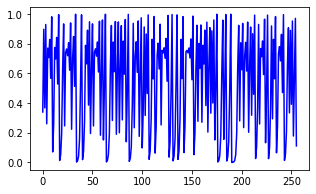

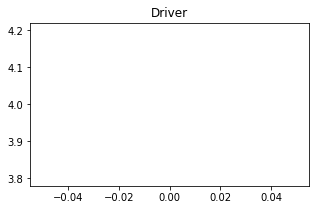

In [52]:
fig2 = plt.figure(2,figsize=(5,3))

if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
    
""" 
ax2 = fig2.gca(projection="3d")
ax2.plot(t[settlingTime:],Xr[:,0],Xr[:,1])
ax2.set_xlabel("Time")
ax2.set_ylabel("Species 1 (standardized)")
ax2.set_zlabel("Species 2 (standardized)")
"""
# ax2.set_title("Rosenzweig MacArthur")
plt.savefig("Raw Data")

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(5,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

plt.savefig("Individual Dimensions")
        
if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(5,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver")
        axD.plot(gtsr, c="tab:orange")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
            
    plt.savefig("Drivers")
        
plt.show()

In [53]:
def peakToPeakInterval(X, t, a,b,c):
    imax0 = Xr[a:b].argmax() + a
    imax1 = Xr[b:c].argmax() + b
    return t[imax1] - t[imax0]


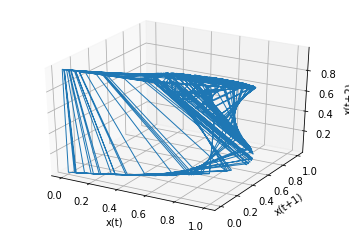

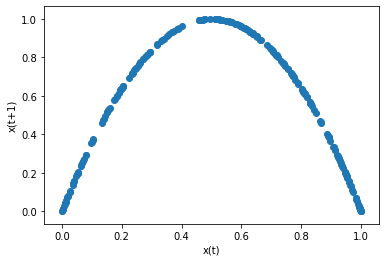

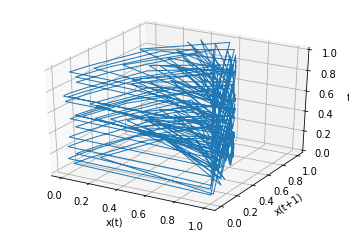

In [54]:
def poincare3d(timeseries):
    eeee, yyyy = delayEmbed(timeseries, 0, 3, 1)
    figPP = plt.figure()
    axPP = figPP.gca(projection="3d")
    axPP.plot(eeee[:,0],eeee[:,1],eeee[:,2],linewidth=1)
    axPP.set_xlabel("x(t)")
    axPP.set_ylabel("x(t+1)")
    axPP.set_zlabel("x(t+2)")
    plt.show()
    
def poincare2d(timeseries):
    figTT, axTT = plt.subplots(1)
    axTT.scatter(timeseries[:-1], timeseries[1:])
    axTT.set_xlabel("x(t)")
    axTT.set_ylabel("x(t+1)")
    plt.show()
    
def poincareT(timeseries):
    figPP = plt.figure()
    axPP = figPP.gca(projection="3d")
    axPP.plot(timeseries[:-1],timeseries[1:],np.linspace(0,1,timeseries.shape[0]-1),linewidth=1)
    axPP.set_xlabel("x(t)")
    axPP.set_ylabel("x(t+1)")
    axPP.set_zlabel("t")
    plt.show()
    
    
poincare3d(Xr)
poincare2d(Xr)
poincareT(Xr)

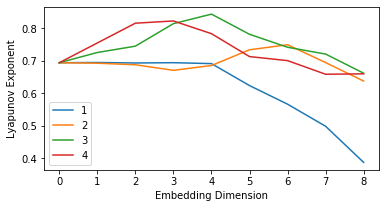

In [55]:
FNNplot(Xr, 8, 4)

In [56]:

Xs, Ys, txs, tys = delayEmbed(Xr, 3, 4, 1, t=t)
Xn, Yn, txn, tyn = delayEmbed(Xr, 3, 1, 1, t=t)

"""
predictionStep = 1
X, t = delayEmbed(Xr,t,[6],1)

testTrainSplit = int(Xr.shape[0] * trainToTest)
Xtrain = X[:testTrainSplit]
Ytrain = Y[:testTrainSplit]
Xtest = X[testTrainSplit:]
Ytest = Y[testTrainSplit:]
"""

'\npredictionStep = 1\nX, t = delayEmbed(Xr,t,[6],1)\n\ntestTrainSplit = int(Xr.shape[0] * trainToTest)\nXtrain = X[:testTrainSplit]\nYtrain = Y[:testTrainSplit]\nXtest = X[testTrainSplit:]\nYtest = Y[testTrainSplit:]\n'

In [57]:
print(txs.shape, Xs.shape, Ys.shape, tys.shape)

(249,) (249, 5) (249, 1) (249,)


In [58]:
# print(X.shape, Y.shape, tx.shape)

print(GMap(Xs[:-1], Ys[:-1], txs[:-1], Xs[-1], txs[-1], 10, 0))
print(Ys[-1])

[[0.1734737]]
[0.11141204]


In [59]:
np.set_printoptions(suppress=True)
print(GMap(Xn[:-1], Yn[:-1], txn[:-1], Xn[-1], txn[-1], 10, 0.1))
print(Yn[-1])

[[0.31584358]]
[0.11141204]


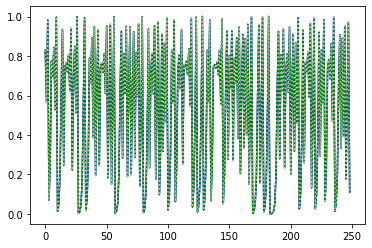

In [69]:
# predictedTSG = leaveOneOut(Xn, Yn, txn, 10, 0.001)
predictedTSG = leaveOneOut(Xs, Ys, txs, 50, 0.1)
predictedTSS = leaveOneOut(Xs, Ys, txs, 50, 0)

predictedTSSN = np.zeros((Xs.shape[0], 1))    
for i in range(0, Xs.shape[0]):
    Xjts = Xs[i].copy()
    Yjts = Ys[i].copy()

    Xjtr = np.delete(Xs, i, axis=0)
    Yjtr = np.delete(Ys, i, axis=0)
    
    prediction = SMap(Xjtr, Yjtr, Xjts, 10)

    predictedTSSN[i] = prediction

figLOU, axLOU = plt.subplots()
axLOU.plot(Ys, c="blue")
axLOU.plot(predictedTSG, c="green", linestyle="-")
axLOU.plot(predictedTSS, c="silver", linestyle="dotted")
# axLOU.plot(predictedTSSN, c="silver", linestyle="dotted")
plt.show()

In [70]:
print(np.sum(abs(predictedTSG - Ys)))
print(np.sum(abs(predictedTSS - Ys)))
print(np.sum(abs(predictedTSSN - Ys)))

# timeit.timeit("leaveOneOut(X, Y, tx, ty, 10, 0.1)", globals=globals())

0.04984942834651429
0.00894905010304346
53.98263334638641


In [62]:
A = np.array([2,3,0],dtype=float)
print(np.power(A, -1, where=(A!=0)))

C = np.array([1,2,1])
D = np.array([[1,2,1],[1,2,2],[-1,2,3]])

[0.5        0.33333333 0.        ]


In [63]:
def likelihoodRatioTest(X, Y, tx, ty, thetaBestS, thetaBest, deltaBest, errThetaDelta):
    nTrials = int(X.shape[0] / 4)
    
    dofS = dofestimation(X, Y, tx, thetaBestS, 0)
    dofG = dofestimation(X, Y, tx, thetaBest, deltaBest)
    dof = abs(dofS - dofG)
    
    teststat = X.shape[0] * np.log(np.min(errThetaDelta[:,0]) / np.min(errThetaDelta))
    
    return (teststat, dof)
    
    # errS, varS = GMapMinError(X, t, predHorizon, thetaVals, np.array([0]), nTrials)
    # errG, varG = GMapMinError(X, t, predHorizon, thetaVals, deltaVals, nTrials)
    
    # return (errS / varS) - (errG / varG)

def likelihoodRatioTest(err1, err2, dof, N):
    lambdaLR = N * np.log(err1 / err2)
    
    if dof == 0:
        return 1
    return 1 - stats.chi2.cdf(lambdaLR,dof)
    
# WRONG, NEED TO USE APPROPRIATE HAT MATRIX, WHICH IS MADE OF 
def dofestimation(X, Y, tx, theta, delta):
    dofest = 0
    for i in range(X.shape[0]):
        pred, hatvector = GMap(X, Y, tx, X[i], tx[i], theta, delta, return_hat=True)
        dofest += hatvector[0,i]
    return dofest
        
def chisig(test_stat, dof):
    if dof == 0:
        return 1
    return 1 - stats.chi2.cdf(lambdaLR,dof)

In [64]:
print(X.shape, t.shape)

(4095, 2) (256,)


In [71]:
nHPvals = 15
predHorizon = 6
nTrials = int(Xr.shape[0] / 3)

thetaVals = np.linspace(1, 100, num=nHPvals)
deltaVals = np.linspace(0, 1, num=nHPvals) ** 2

thetaBest, deltaBest, errThetaDeltaGMap = GMapOptimize(Xs, Ys, txs, thetaVals, deltaVals)
thetaBestS, _ , errThetaSMap = GMapOptimize(Xs, Ys, txs, thetaVals, np.array([[0]]))

print(f"GMap Optimized Params: theta={thetaBest}, delta={deltaBest}")
print(f"SMap Optimized Params: theta={thetaBestS}")

GMap Optimized Params: theta=100.0, delta=0.00510204081632653
SMap Optimized Params: theta=57.57142857142857


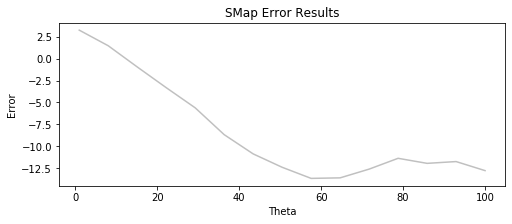

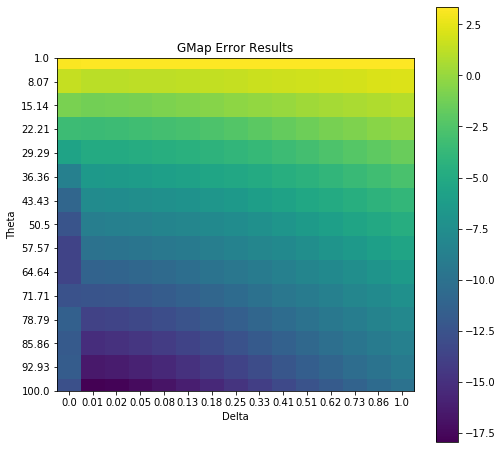

Min SMap Error: 1.1684902054150506e-06, Min GMap Error: 1.6293497986462967e-08
Improvement of GMap: 71.71512258361345


In [72]:
# Theta Optimization
fig1, ax1 = plt.subplots(1, figsize = (8,3))
ax1.plot(thetaVals, np.log(errThetaSMap), c="silver")
ax1.set_title("SMap Error Results")
ax1.set_xlabel("Theta")
ax1.set_ylabel("Error")

fig2, ax2 = plt.subplots(1, figsize = (8,8))
plt.colorbar(ax2.imshow(np.log(errThetaDeltaGMap)))
ax2.set_xticks(range(nHPvals))
ax2.set_xticklabels(list(np.round(deltaVals,2)))
ax2.set_xlabel("Delta")
ax2.set_yticks(np.arange(nHPvals))
ax2.set_yticklabels(list(np.round(thetaVals,2)))
ax2.set_ylabel("Theta")
ax2.set_title("GMap Error Results")
plt.show()

print(f"Min SMap Error: {np.min(errThetaSMap)}, Min GMap Error: {np.min(errThetaDeltaGMap)}")
print(f"Improvement of GMap: {np.min(errThetaSMap)/np.min(errThetaDeltaGMap)}")

In [79]:
thetaBest, deltaBest, errThetaDeltaGMap = GMapOptimize(Xn, Yn, txn, thetaVals, deltaVals)
thetaBestS, _ , errThetaSMap = GMapOptimize(Xn, Yn, txn, thetaVals, np.array([[0]]))

print(f"GMap Optimized Params: theta={thetaBest}, delta={deltaBest}")
print(f"SMap Optimized Params: theta={thetaBestS}")

GMap Optimized Params: theta=100.0, delta=0.0
SMap Optimized Params: theta=100.0


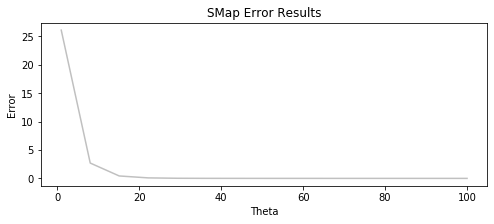

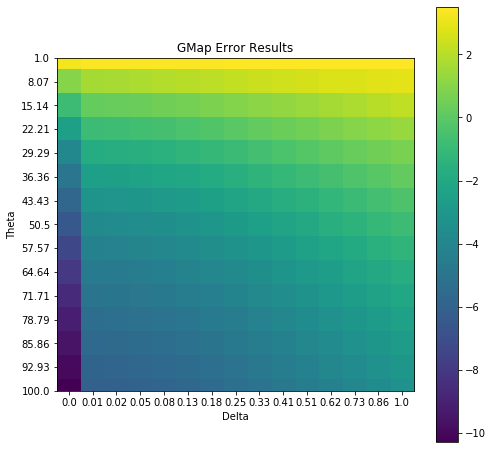

Min SMap Error: 3.447282966844418e-05, Min GMap Error: 3.447282966844418e-05
Improvement of GMap: 1.0


In [80]:
# Theta Optimization
fig1, ax1 = plt.subplots(1, figsize = (8,3))
ax1.plot(thetaVals, errThetaSMap, c="silver")
ax1.set_title("SMap Error Results")
ax1.set_xlabel("Theta")
ax1.set_ylabel("Error")

fig2, ax2 = plt.subplots(1, figsize = (8,8))
plt.colorbar(ax2.imshow(np.log(errThetaDeltaGMap)))
ax2.set_xticks(range(nHPvals))
ax2.set_xticklabels(list(np.round(deltaVals,2)))
ax2.set_xlabel("Delta")
ax2.set_yticks(np.arange(nHPvals))
ax2.set_yticklabels(list(np.round(thetaVals,2)))
ax2.set_ylabel("Theta")
ax2.set_title("GMap Error Results")
plt.show()

print(f"Min SMap Error: {np.min(errThetaSMap)}, Min GMap Error: {np.min(errThetaDeltaGMap)}")
print(f"Improvement of GMap: {np.min(errThetaSMap)/np.min(errThetaDeltaGMap)}")

In [73]:
likelihoodRatioTest(0.00507920611875460,0.002629610881228081,251.82806184267793-248.97132899512275, 256)

0.0

In [74]:
0.00027597124820936936/3.2678957725794046e-07

844.4921974715878

4.893472575250994


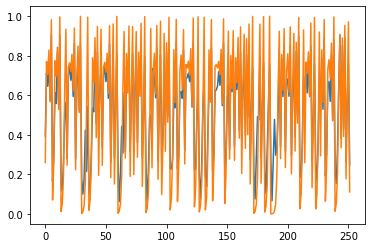

In [75]:
EEEE = leaveOneOut(Xn,Yn,txn,20,1)
print(np.sum((EEEE - Yn)**2))
plt.plot(EEEE)
plt.plot(Yn)

In [78]:
# print(np.trace(hatG)) 
print(f"GMap dof: {dofestimation(Xn,Yn,txn, thetaBest, deltaBest)}")
print(f"SMap dof: {dofestimation(Xs,Ys,txs, thetaBestS, 0)}")
# hat matrix trace = 1.7718827495393625

GMap dof: 214.93011237718912
SMap dof: 242.52378998195445


In [ ]:
# Theta Optimization
fig1, ax1 = plt.subplots(1, figsize = (8,3))
ax1.plot(thetaVals, errThetaSMap, c="silver")
ax1.set_title("SMap Error Results")
ax1.set_xlabel("Theta")
ax1.set_ylabel("Error")

fig2, ax2 = plt.subplots(1, figsize = (8,8))
plt.colorbar(ax2.imshow(np.log(errThetaDeltaGMap)))
ax2.set_xticks(range(nHPvals))
ax2.set_xticklabels(list(np.round(deltaVals,2)))
ax2.set_xlabel("Delta")
ax2.set_yticks(np.arange(nHPvals))
ax2.set_yticklabels(list(np.round(thetaVals,2)))
ax2.set_ylabel("Theta")
ax2.set_title("GMap Error Results")
plt.show()

print(f"Min SMap Error: {np.min(errThetaSMap)}, Min GMap Error: {np.min(errThetaDeltaGMap)}")
print(f"Improvement of GMap: {np.min(errThetaSMap)/np.min(errThetaDeltaGMap)}")

In [ ]:
# print(f"DOF = {np.trace(hatG)}")
# print(thetaBest)
print(X)

In [ ]:
predictedTSG = leaveOneOut(Xn, Yn, txn, thetaBest, 1)
predictedTSS = leaveOneOut(Xs, Ys, txs, thetaBestS, 0)

In [ ]:
figLOU, axLOU = plt.subplots()
axLOU.plot(Ys, c="blue")
axLOU.plot(predictedTSG[2:], c="green", linestyle="-")
axLOU.plot(predictedTSS, c="silver", linestyle="dotted")
plt.show()

In [ ]:
print(np.sum(predictedTSS - Ys))
print(np.sum(predictedTSG[2:] - Ys))

In [ ]:
lambdaLR, dof = likelihoodRatioTest(X, Y, tx, ty, thetaBestS, thetaBest, deltaBest, errThetaDeltaGMap)


In [ ]:
print(f"LRT Score w/ steps = {lambdaLR}, DOF difference = {dof}")
print(f"Probability of SMap Superiority: {chisig(lambdaLR, dof)}")

In [ ]:
# SUMMARY
print(f"GMap Optimized Params: theta={thetaBest}, delta={deltaBest}")
print(f"SMap Optimized Params: theta={thetaBestS}")

print(f"GMap dof: {dofestimation(X,Y,tx, thetaBest, deltaBest)}")
print(f"SMap dof: {dofestimation(X,Y,tx, thetaBestS, 0)}")

print(f"Min SMap Error: {np.min(errThetaSMap)}, Min GMap Error: {np.min(errThetaDeltaGMap)}")
print(f"Improvement of GMap: {np.min(errThetaSMap)/np.min(errThetaDeltaGMap)}")

print(f"LRT Score w/ steps = {lambdaLR}, DOF difference = {dof}")
print(f"Probability of SMap Superiority: {chisig(lambdaLR, dof)}")